In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import missingno as msno
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,RepeatedStratifiedKFold,train_test_split
from sklearn.metrics import precision_score,confusion_matrix
from sklearn import tree
import warnings
# Uyarıları gizlemek, çıktıyı daha temiz yapar
warnings.filterwarnings("ignore")

# Colab'e dosya yüklemek için gerekli kütüphane
from google.colab import files

print("Kütüphane yüklemeleri tamamlandı.")

Kütüphane yüklemeleri tamamlandı.


Lütfen açılan pencereden 'water_potability.csv' dosyasını seçin.


Saving water_potability.csv to water_potability (2).csv

'water_potability (2).csv' dosyası başarıyla yüklendi ve okundu.
1. Ön İşleme Tamamlandı. Eksik değerler medyan ile dolduruldu.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None


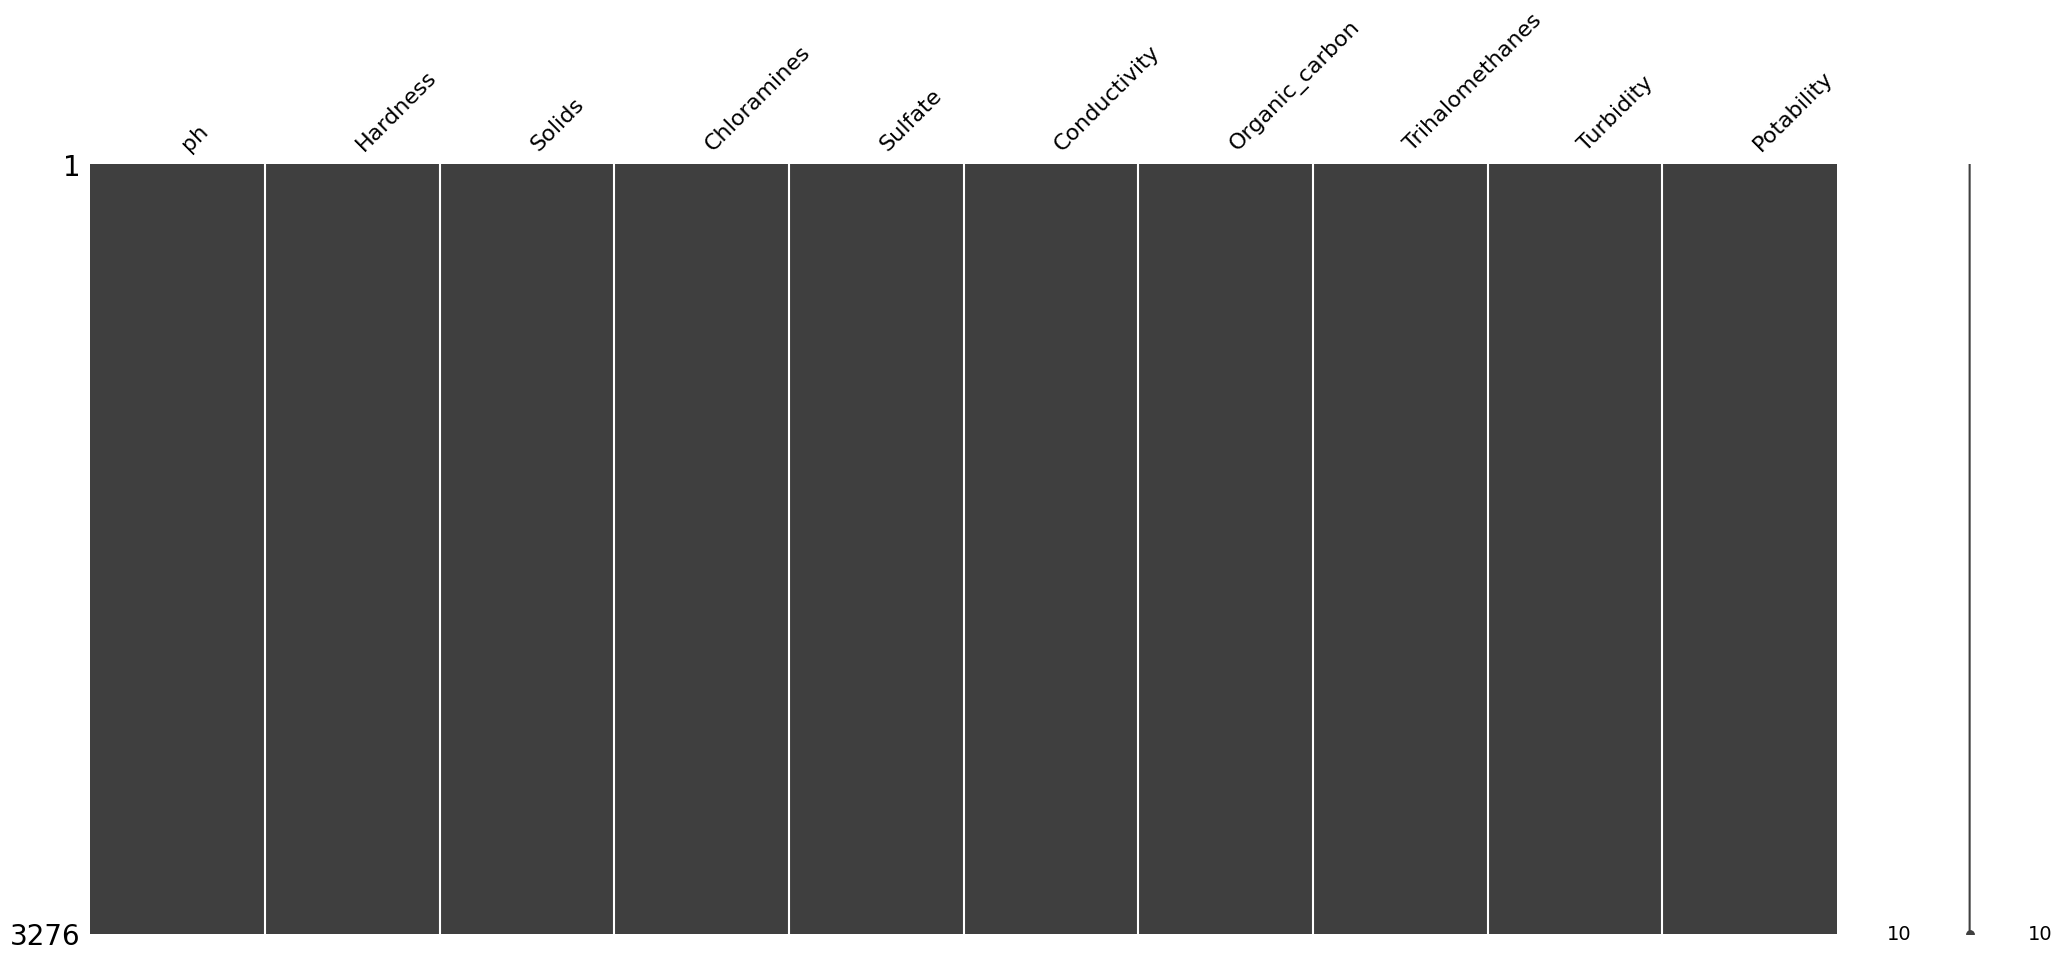

In [5]:
# ==============================================================================
# 1. Veri Yükleme ve Ön İşleme (COLAB UYUMU)
# ==============================================================================

# DOSYA YÜKLEME KISMI
print("Lütfen açılan pencereden 'water_potability.csv' dosyasını seçin.")
uploaded = files.upload()

# Yüklendikten sonra, dosya adını alıyoruz
file_name = list(uploaded.keys())[0]

# Yüklenen dosyayı okuma
df = pd.read_csv(file_name)

print(f"\n'{file_name}' dosyası başarıyla yüklendi ve okundu.")

# Eksik değerleri doldurma (Imputation): Medyan kullanımı
df['ph'] = df['ph'].fillna(df['ph'].median())
df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].median())
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].median())

print("1. Ön İşleme Tamamlandı. Eksik değerler medyan ile dolduruldu.")
print(df.info())

# Eksik değerleri gösteren matris (Kontrol amaçlı)
msno.matrix(df)
plt.show()


2. Potability Dağılım Grafiği gösterildi.


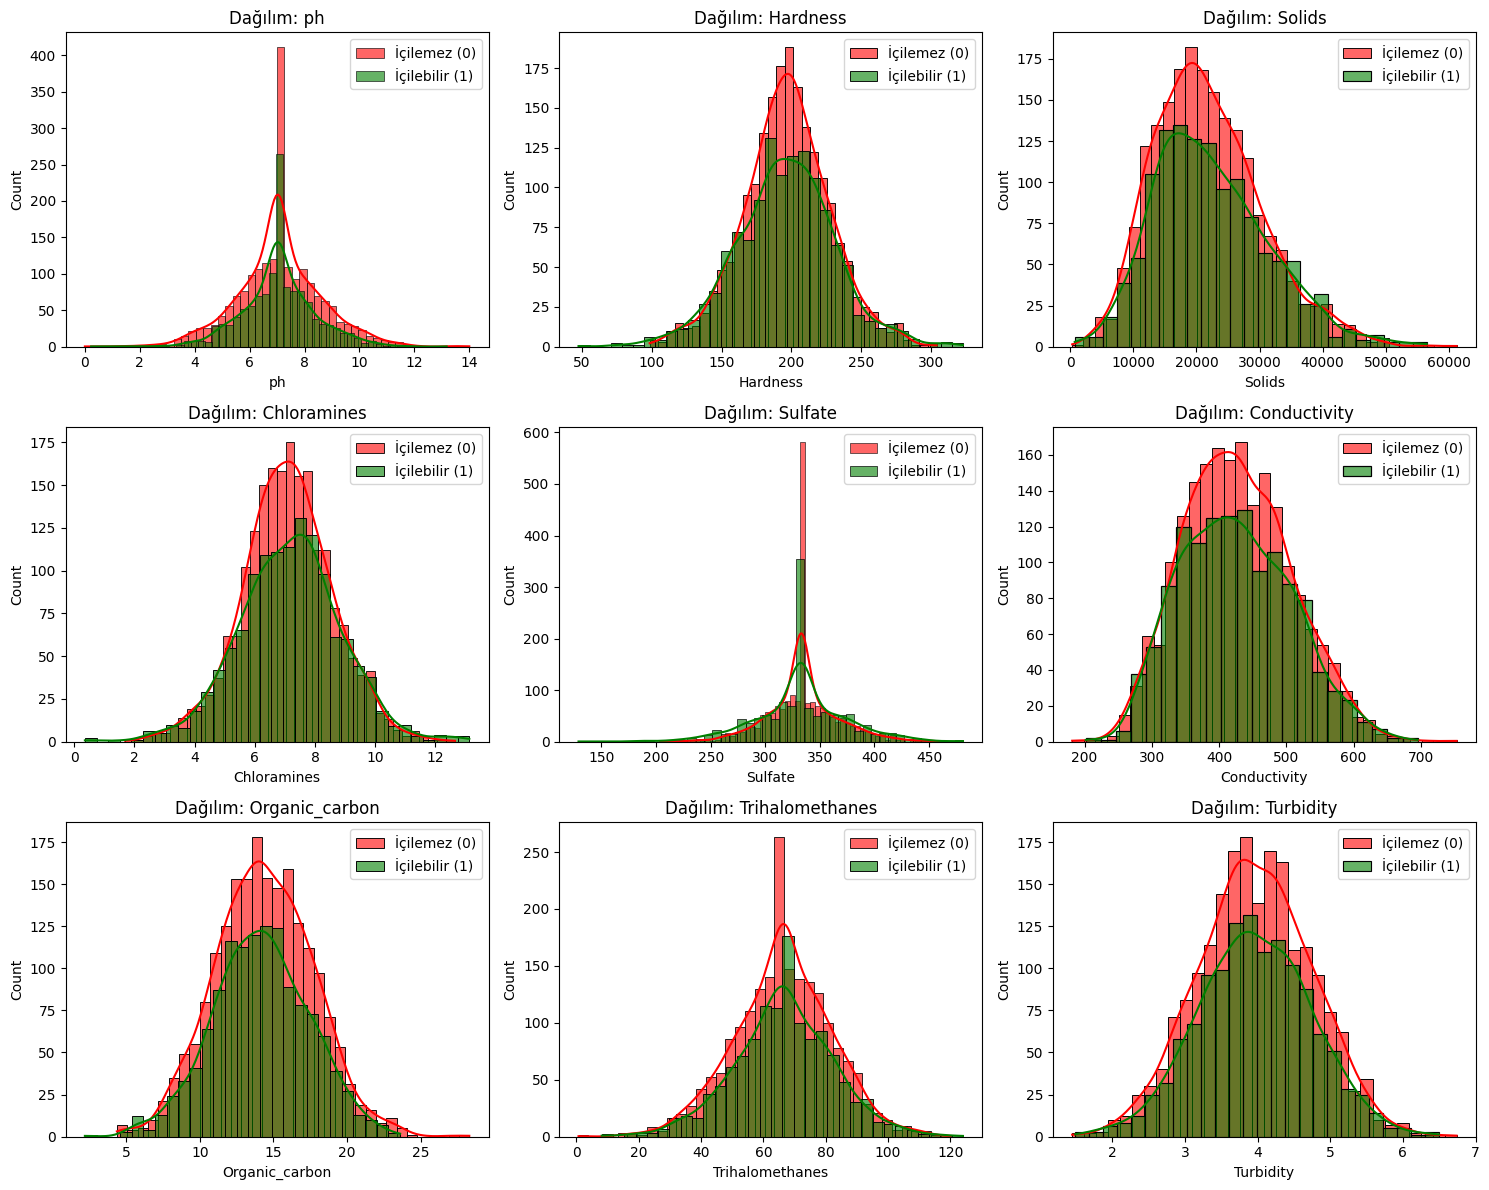


4. Özellik Dağılım Karşılaştırması (Histogramlar) başarıyla gösterildi.


In [6]:
# ==============================================================================
# 2. Pasta Grafiği Oluşturma (Potability Dağılımı)
# ==============================================================================
d=pd.DataFrame(df["Potability"].value_counts())
d.columns = ["Number of Sample"]
d.index = ["Not Potable", "Potable"]

fig=px.pie(d,values="Number of Sample",names=d.index,hole=0.35,opacity=0.8,
           labels={"names":"Potability","Number of Sample":"Number of Sample"})
fig.update_layout(title=dict(text="Pie Chart of Potability"))
fig.update_traces(textposition="outside",textinfo="percent+label")
fig.show() # Colab'de gösterim için fig.show() kullanıldı
# fig.write_html("potability_pie_chart.html")
print("\n2. Potability Dağılım Grafiği gösterildi.")


# ==============================================================================
# 4. İçilebilirlik Durumuna Göre Özellik Dağılımı Karşılaştırması
# ==============================================================================
non_potable=df.query("Potability==0")
Potable=df.query("Potability==1")

plt.figure(figsize=(15, 12))
for ax_idx, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, ax_idx + 1)

    sns.histplot(data=non_potable, x=col, kde=True, label="İçilemez (0)", color='red', alpha=0.6)
    sns.histplot(data=Potable, x=col, kde=True, label="İçilebilir (1)", color='green', alpha=0.6)

    plt.title(f'Dağılım: {col}')
    plt.xlabel(col)
    plt.legend()

plt.tight_layout()
plt.show()

print("\n4. Özellik Dağılım Karşılaştırması (Histogramlar) başarıyla gösterildi.")

In [10]:
# ==============================================================================
# 5. Veri Setini Ayırma (train_test_split)
# ==============================================================================
X = df.drop("Potability", axis=1)
y = df["Potability"]            # Buradaki boşluklar temizlendi

# Eğitim (%70) ve Test (%30) Kümelerine Bölme
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("\n" + "=" * 50)
print(f"5. Veri Ayırma Tamamlandı. Eğitim Boyutu: {len(X_train)}, Test Boyutu: {len(X_test)}")
print("=" * 50)


# ==============================================================================
# 6. Model Eğitimi ve Hızlandırılmış Hiperparametre Optimizasyonu (Random Forest)
# ==============================================================================
print("6. Random Forest Modeli Eğitimi ve Optimizasyonu Başlatılıyor...")
print("NOT: Hızlandırmak için n_iter=15 ve n_repeats=1 olarak ayarlanmıştır.")

rf_model = RandomForestClassifier(random_state=42)

param_dist = {
    # Parametre aralığı önceki tavsiyeye göre optimize edildi
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

# ÇAPRAZ DOĞRULAMA AZALTILDI: n_repeats=1 kullanıldı
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# Randomized Search uygulama
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=15, # DENEME SAYISI AZALTILDI
    cv=cv,
    scoring='precision',
    verbose=2, # İLERLEMEYİ GÖRMEK İÇİN
    n_jobs=-1,
    random_state=42
)

rf_random_search.fit(X_train, y_train)

best_rf_model = rf_random_search.best_estimator_
print("\nEn İyi Random Forest Hiperparametreleri Bulundu.")
print(f"En İyi Parametreler: {rf_random_search.best_params_}")


5. Veri Ayırma Tamamlandı. Eğitim Boyutu: 2293, Test Boyutu: 983
6. Random Forest Modeli Eğitimi ve Optimizasyonu Başlatılıyor...
NOT: Hızlandırmak için n_iter=15 ve n_repeats=1 olarak ayarlanmıştır.
Fitting 5 folds for each of 15 candidates, totalling 75 fits

En İyi Random Forest Hiperparametreleri Bulundu.
En İyi Parametreler: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy'}



7. Model Değerlendirmesi Başlatılıyor...

En İyi Random Forest Modelinin Test Verisindeki Kesinlik (Precision Score): 0.7890


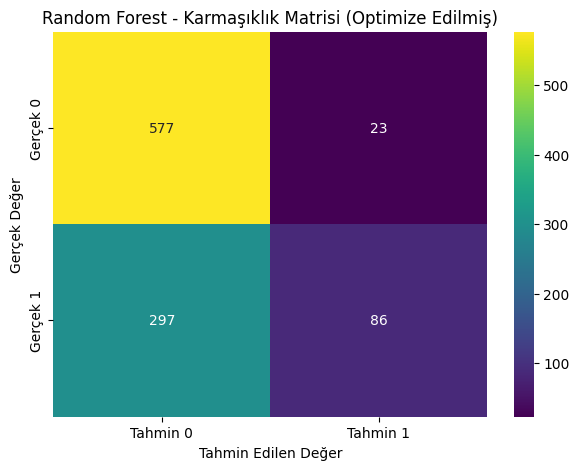


8. Özellik Önem Derecesi (Feature Importance) Analizi

Özellik Önem Sıralaması:
           Feature  Importance
4          Sulfate    0.159380
0               ph    0.154473
3      Chloramines    0.124355
1         Hardness    0.123808
2           Solids    0.110814
5     Conductivity    0.085384
7  Trihalomethanes    0.083477
8        Turbidity    0.079710
6   Organic_carbon    0.078600


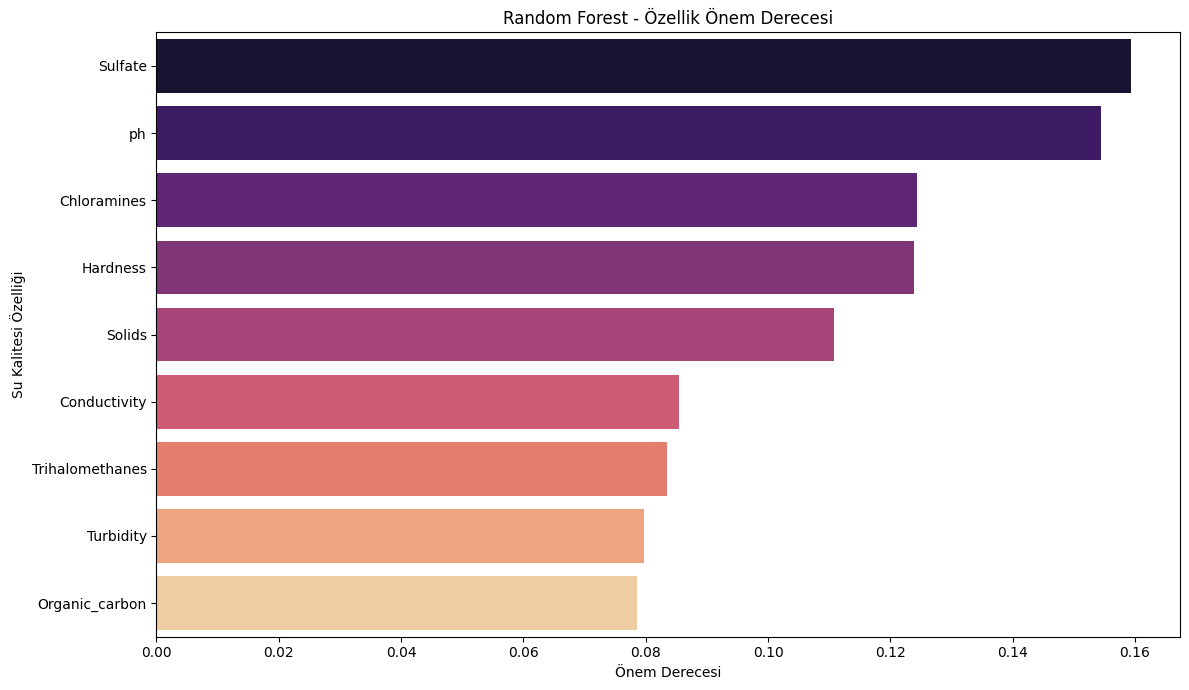


Kod Çalışması Başarıyla Tamamlandı.


In [11]:
# ==============================================================================
# 7. Model Tahmini ve Değerlendirme
# ==============================================================================
print("\n7. Model Değerlendirmesi Başlatılıyor...")

y_pred = best_rf_model.predict(X_test)

precision = precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)


print(f"\nEn İyi Random Forest Modelinin Test Verisindeki Kesinlik (Precision Score): {precision:.4f}")

# Karmaşıklık Matrisi görselleştirme
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Tahmin 0', 'Tahmin 1'],
            yticklabels=['Gerçek 0', 'Gerçek 1'])
plt.title('Random Forest - Karmaşıklık Matrisi (Optimize Edilmiş)')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen Değer')
plt.show()


# ==============================================================================
# 8. Özellik Önem Derecesi (Feature Importance) Analizi
# ==============================================================================
print("\n" + "=" * 50)
print("8. Özellik Önem Derecesi (Feature Importance) Analizi")

importances = best_rf_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nÖzellik Önem Sıralaması:")
print(feature_importance_df)

# Özellik Önem Grafiğini Oluşturma
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('Random Forest - Özellik Önem Derecesi')
plt.xlabel('Önem Derecesi')
plt.ylabel('Su Kalitesi Özelliği')
plt.tight_layout()
plt.show()

print("\nKod Çalışması Başarıyla Tamamlandı.")
print("=" * 50)


9. Karar Ağacı Görselleştirmesi (Decision Tree)


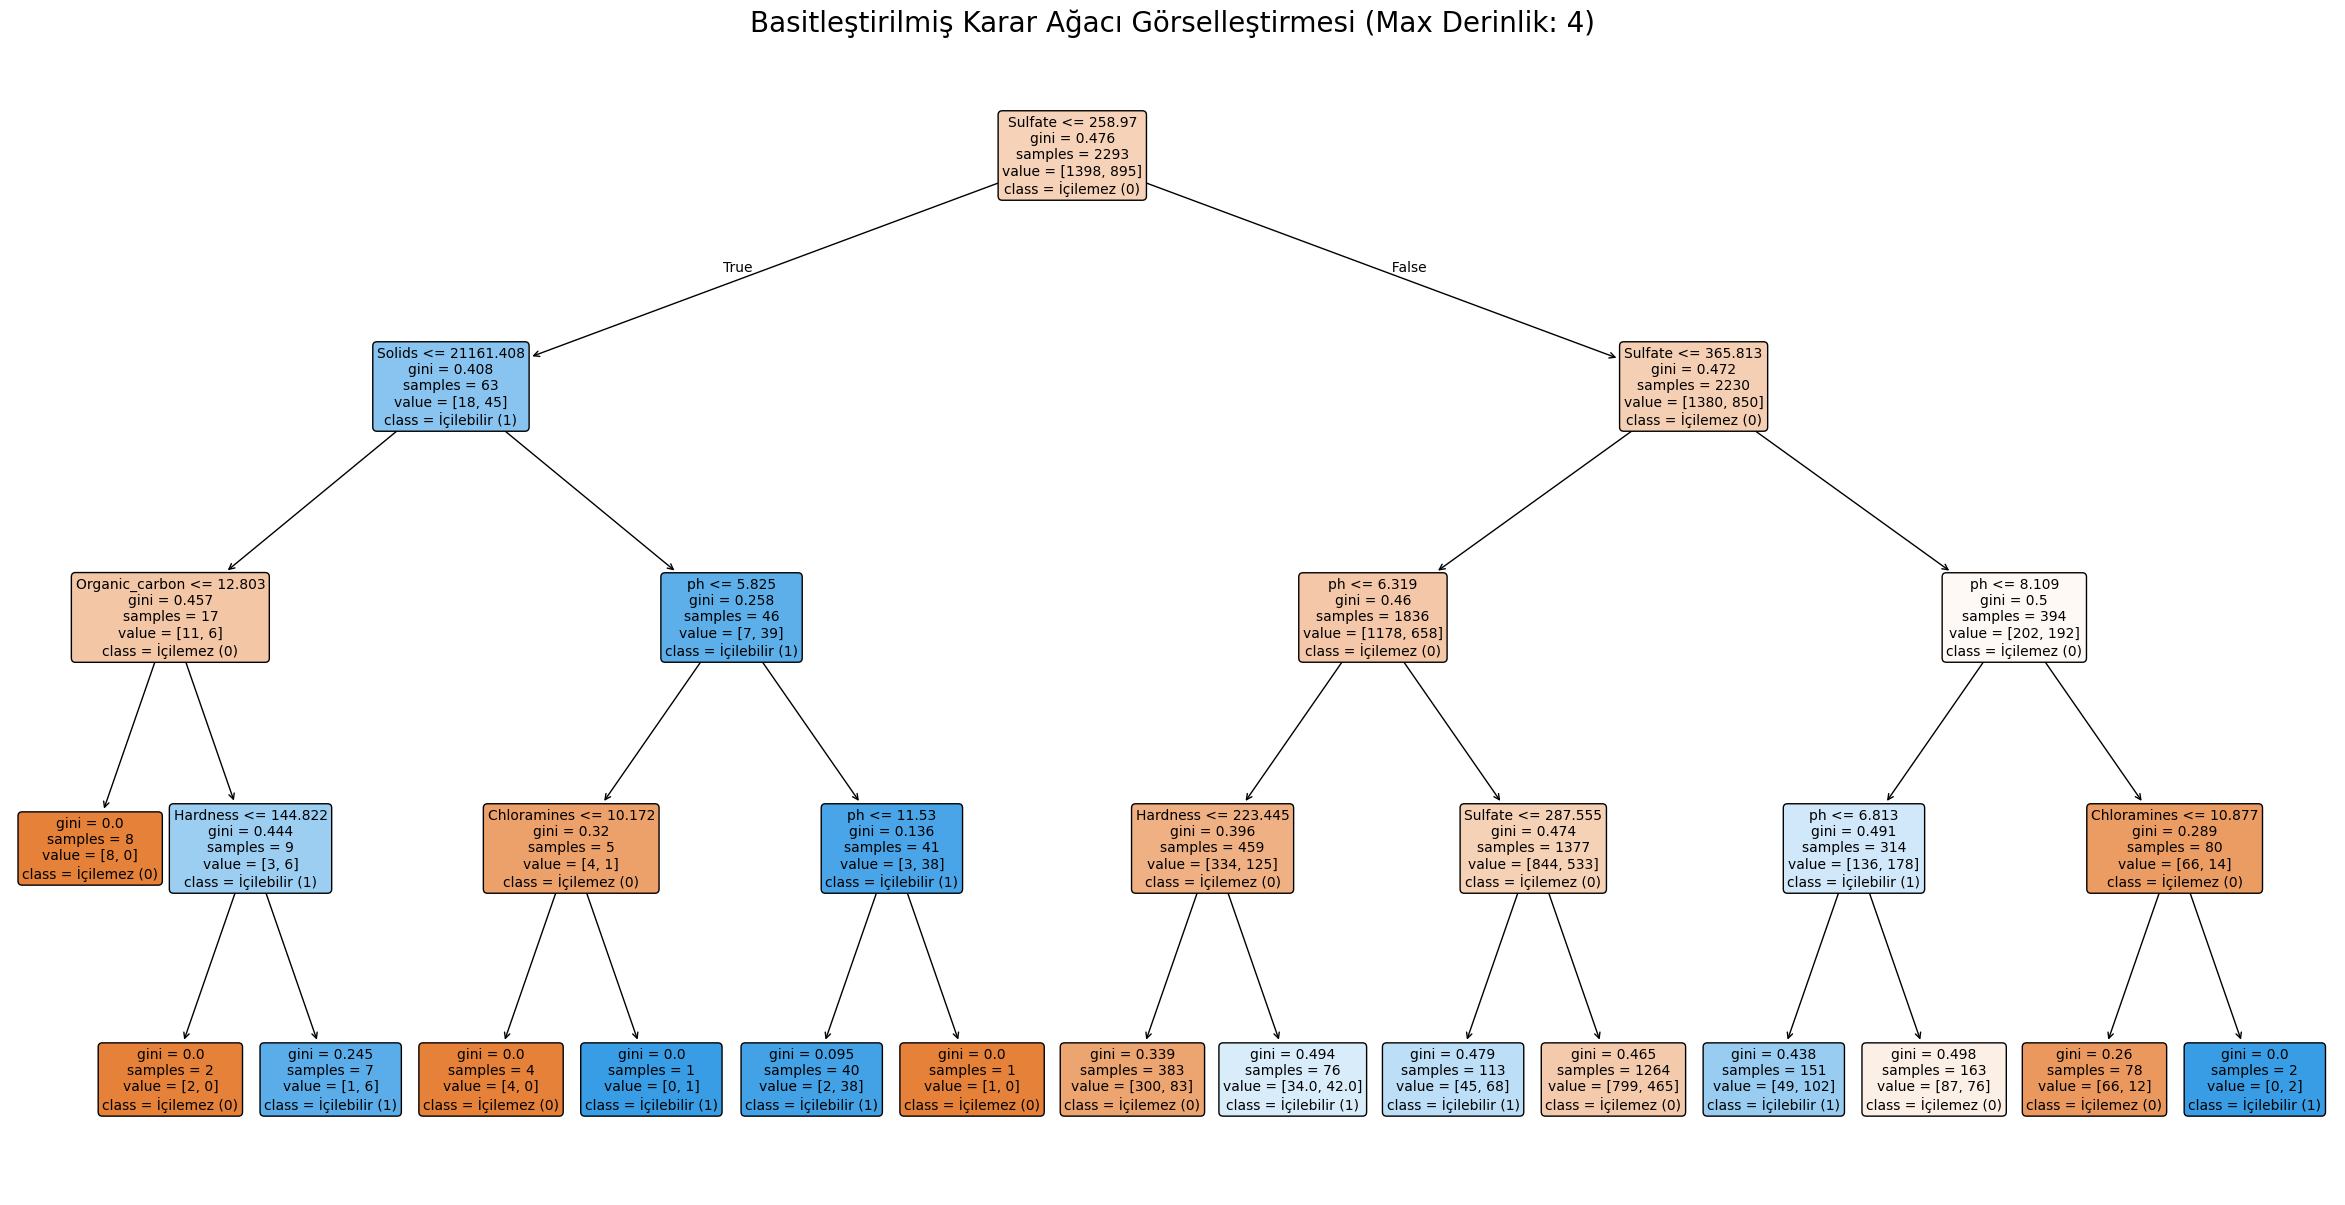


Basitleştirilmiş Karar Ağacı görselleştirmesi başarıyla tamamlandı.


In [12]:
# ==============================================================================
# 9. Karar Ağacı Görselleştirmesi
# ==============================================================================
print("\n" + "=" * 50)
print("9. Karar Ağacı Görselleştirmesi (Decision Tree)")

# 1. Görselleştirmek için basit bir Karar Ağacı modeli eğitme
# Sadece görselleştirme amaçlı olduğundan aşırı derinliği engelliyoruz.
dt_simple_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_simple_model.fit(X_train, y_train)

# 2. Ağacı Görselleştirme
# plt boyutu büyütüldü ki detaylar daha net görülebilsin.
plt.figure(figsize=(30, 15))

# tree.plot_tree fonksiyonu ile ağaç çizimi
tree.plot_tree(dt_simple_model,
               feature_names=X.columns.tolist(), # Özellik isimleri
               class_names=['İçilemez (0)', 'İçilebilir (1)'], # Sınıf isimleri
               filled=True, # Renklendirme
               rounded=True, # Yuvarlak köşeler
               max_depth=4, # Maksimum 4 seviye göster
               fontsize=10)
plt.title('Basitleştirilmiş Karar Ağacı Görselleştirmesi (Max Derinlik: 4)', fontsize=20)
plt.show()

print("\nBasitleştirilmiş Karar Ağacı görselleştirmesi başarıyla tamamlandı.")
print("=" * 50)

In [13]:
# ==============================================================================
# 5. Veri Setini Ayırma (train_test_split)
# ==============================================================================
# X (Özellikler) ve y (Hedef Değişken) tanımlanıyor
X = df.drop("Potability", axis=1)
y = df["Potability"]

# Eğitim (%70) ve Test (%30) Kümelerine Bölme
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("\n" + "=" * 50)
print(f"5. Veri Ayırma Tamamlandı. Eğitim Boyutu: {len(X_train)}, Test Boyutu: {len(X_test)}")
print("=" * 50)


# ==============================================================================
# 6. Model Eğitimi ve Hızlandırılmış Hiperparametre Optimizasyonu (Random Forest)
# ==============================================================================
print("6. Random Forest Modeli Eğitimi ve Optimizasyonu Başlatılıyor (RandomizedSearchCV)...")
print("NOT: Hızlandırmak için n_iter=15 ve n_repeats=1 olarak ayarlanmıştır.")

rf_model = RandomForestClassifier(random_state=42)

# Hiperparametre aralığı tanımlama (Grid)
param_dist = {
    'n_estimators': [100, 200],             # Ağaç sayısı
    'max_depth': [10, 20, None],            # Maksimum ağaç derinliği
    'min_samples_split': [2, 5],            # Düğümü bölmek için minimum örnek
    'min_samples_leaf': [1, 2],             # Yaprakta minimum örnek
    'criterion': ['gini', 'entropy']
}

# ÇAPRAZ DOĞRULAMA AYARI: Daha hızlı bitirmesi için n_repeats=1 kullanıldı
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# Randomized Search uygulama
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=15,    # Denenecek kombinasyon sayısı (Hız için 50'den 15'e düşürüldü)
    cv=cv,
    scoring='precision',
    verbose=2,    # İlerlemeyi ekranda görmek için verbose=2 ayarlandı
    n_jobs=-1,    # Tüm Colab CPU/GPU çekirdeklerini kullanır
    random_state=42
)

# Modeli eğitme
rf_random_search.fit(X_train, y_train)

best_rf_model = rf_random_search.best_estimator_
print("\nEn İyi Random Forest Hiperparametreleri Bulundu.")
print(f"En İyi Parametreler: {rf_random_search.best_params_}")
print("-" * 50)


5. Veri Ayırma Tamamlandı. Eğitim Boyutu: 2293, Test Boyutu: 983
6. Random Forest Modeli Eğitimi ve Optimizasyonu Başlatılıyor (RandomizedSearchCV)...
NOT: Hızlandırmak için n_iter=15 ve n_repeats=1 olarak ayarlanmıştır.
Fitting 5 folds for each of 15 candidates, totalling 75 fits

En İyi Random Forest Hiperparametreleri Bulundu.
En İyi Parametreler: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy'}
--------------------------------------------------


In [14]:
import os
import zipfile
from google.colab import files

# ==============================================================================
# 10. Grafiklerin Kaydedilmesi ve İndirilmesi
# ==============================================================================

# Kayıt için bir klasör oluşturma
output_dir = "proje_grafikleri"
os.makedirs(output_dir, exist_ok=True)
print(f"\n10. Grafikler '{output_dir}' klasörüne kaydediliyor...")

# --- 1. Dağılım Karşılaştırması Grafiği (Blok 4) ---
plt.figure(figsize=(15, 12))
non_potable=df.query("Potability==0")
Potable=df.query("Potability==1")
for ax_idx, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, ax_idx + 1)
    sns.histplot(data=non_potable, x=col, kde=True, label="İçilemez (0)", color='red', alpha=0.6)
    sns.histplot(data=Potable, x=col, kde=True, label="İçilebilir (1)", color='green', alpha=0.6)
    plt.title(f'Dağılım: {col}')
    plt.xlabel(col)
    plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '4_Feature_Dagilim_Karsilastirmasi.png'))
plt.close() # Belleği temizlemek için figürü kapat

# --- 2. Karmaşıklık Matrisi (Blok 7) ---
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Tahmin 0', 'Tahmin 1'],
            yticklabels=['Gerçek 0', 'Gerçek 1'])
plt.title('Random Forest - Karmaşıklık Matrisi (Optimize Edilmiş)')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen Değer')
plt.savefig(os.path.join(output_dir, '7_Confusion_Matrix.png'))
plt.close()

# --- 3. Özellik Önem Derecesi Grafiği (Blok 8) ---
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('Random Forest - Özellik Önem Derecesi')
plt.xlabel('Önem Derecesi')
plt.ylabel('Su Kalitesi Özelliği')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '8_Feature_Importance_Grafik.png'))
plt.close()

# --- 4. Karar Ağacı Görselleştirmesi (Blok 9) ---
plt.figure(figsize=(30, 15))
tree.plot_tree(dt_simple_model,
               feature_names=X.columns.tolist(),
               class_names=['İçilemez (0)', 'İçilebilir (1)'],
               filled=True,
               rounded=True,
               max_depth=4,
               fontsize=10)
plt.title('Basitleştirilmiş Karar Ağacı Görselleştirmesi (Max Derinlik: 4)', fontsize=20)
plt.savefig(os.path.join(output_dir, '9_Decision_Tree_Gorsellestirme.png'))
plt.close()

# --- 5. Eksik Değer Matrisi (Blok 1) ---
msno.matrix(df)
plt.savefig(os.path.join(output_dir, '1_Missing_Value_Matrix.png'))
plt.close()


# --- TÜM GRAFİKLERİ ZIPLEYİP İNDİRME ---
zip_filename = 'proje_grafikleri_cikti.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files_in_dir in os.walk(output_dir):
        for file in files_in_dir:
            file_path = os.path.join(root, file)
            # Zip dosyasına eklerken klasör yolunu kaldırır
            zipf.write(file_path, os.path.relpath(file_path, output_dir))

print(f"\nTüm grafikler '{zip_filename}' adıyla sıkıştırıldı.")
files.download(zip_filename)
print("İndirme işlemi başlatıldı. Lütfen bilgisayarınıza kaydedin.")


10. Grafikler 'proje_grafikleri' klasörüne kaydediliyor...

Tüm grafikler 'proje_grafikleri_cikti.zip' adıyla sıkıştırıldı.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

İndirme işlemi başlatıldı. Lütfen bilgisayarınıza kaydedin.
